# Project

## 0. Introduction

### Imports

We start by importing all the libraries used in this project.

In [1]:
from gemseo.algos.parameter_space import ParameterSpace
from gemseo.core.mdo_scenario import MDOScenario

from gemseo.algos.design_space import DesignSpace
from numpy import array

from gemseo.api import configure_logger

# discipline
from gemseo.api import create_discipline
from gemseo_mlearning.api import sample_discipline

from gemseo.uncertainty.sensitivity.sobol.analysis import SobolAnalysis

from MARILib_obj_edu.marilib.utils import unit

from gemseo.api import create_design_space
from gemseo.api import create_parameter_space
from gemseo.api import create_surrogate
from gemseo.api import create_scenario

from gemseo.mlearning.qual_measure.r2_measure import R2Measure
from gemseo.mlearning.qual_measure.rmse_measure import RMSEMeasure

%load_ext autoreload
%autoreload 2

### Classes & Function

The goal is to minimize the Maximum Take-Off Weight which is one of the outputs of the following function.

In [4]:
from h2_turbofan.turbofan_h2_class import H2TurboFan
disc = H2TurboFan()

However, that function is costly to execute. Thus, we will create a surrogate model that approximates it well enough to run an optimization problem.

Then, we create some classes depending on the Subproblem.

In [8]:
class XVar_UDefault(DesignSpace):
    def __init__(self):
        super().__init__()
        self.thrust = self.add_variable('thrust', value=unit.N_kN(121), l_b=unit.N_kN(100), u_b=unit.N_kN(150))
        self.bpr = self.add_variable('bpr', value=9, l_b=5, u_b=12)
        self.area = self.add_variable('area', value=164, l_b= 120, u_b=200)
        self.aspect_ratio = self.add_variable('aspect_ratio', value=9, l_b=7 , u_b=12)

# class XDefault_UVar(ParameterSpace):
#     def __init__(self):
#         super().__init__()
#         self.drag = self.add_random_variable("drag", "OTTriangularDistribution", minimum=0.8, mode=0.845, maximum=0.85)
#         self.sfc = self.add_random_variable("sfc", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
#         self.mass = self.add_random_variable("mass", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
#         self.tvi = self.add_random_variable("tvi", "OTTriangularDistribution", minimum=0.25, mode=0.3, maximum=0.305)
#         self.tgi = self.add_random_variable("tgi", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)

# class XVar_Uvar(ParameterSpace):
#     def __init__(self):
#         super().__init__()
#         self.thrust = self.add_variable('thrust', value=unit.N_kN(121), l_b=unit.N_kN(100), u_b=unit.N_kN(150))
#         self.bpr = self.add_variable('bpr', value=9, l_b=5, u_b=12)
#         self.area = self.add_variable('area', value=164, l_b= 120, u_b=200)
#         self.aspect_ratio = self.add_variable('aspect_ratio', value=9, l_b=7 , u_b=12)
#         self.drag = self.add_random_variable("drag", "OTTriangularDistribution", minimum=0.8, mode=0.845, maximum=0.85)
#         self.sfc = self.add_random_variable("sfc", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
#         self.mass = self.add_random_variable("mass", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
#         self.tvi = self.add_random_variable("tvi", "OTTriangularDistribution", minimum=0.25, mode=0.3, maximum=0.305)
#         self.tgi = self.add_random_variable("tgi", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)

In [9]:
from gemseo.api import create_design_space
design_space1 = create_design_space()
design_space1.name = "design_space1"

# Engine maximum thrust (100 kN ≤ thrust ≤ 150 kN)
design_space1.add_variable("thrust",
    l_b=unit.N_kN(100),
    u_b=unit.N_kN(150),
    value=H2TurboFan.DEFAULT_DESIGN_VALUES["thrust"]
)
# Engine Bypass Ratio (BPR) (5 ≤ BPR ≤ 12 )
design_space1.add_variable("bpr",
    l_b=5.,
    u_b=12.,
    value=H2TurboFan.DEFAULT_DESIGN_VALUES["bpr"]
)
# Wing area (120 m² ≤ area ≤ 200 m²)
design_space1.add_variable("area",
    l_b=120.,
    u_b=200.,
    value=H2TurboFan.DEFAULT_DESIGN_VALUES["area"]
)
# Wing aspect ratio (7 ≤ ar ≤ 12)
design_space1.add_variable("aspect_ratio",
    l_b=7.,
    u_b=12,
    value=H2TurboFan.DEFAULT_DESIGN_VALUES["aspect_ratio"]
)

## I. Sub-Problem 1

We will create a surrogate model of $g: x \mapsto g(x)=f\left(x, u_{\text {default }}\right)$ to approximate the objective and constraints of the design problem with respect to the design parameters $x$. Then, we will use this surrogate model in an optimization process to minimize the objective whilst ensuring the constraints by varying the design parameters.

### I.1. Creating the surrogate model

We start by creating a discipline with a DesignSpace XVar_UDefault (x varies, u is default), 30 points are computed.

In [10]:
# we sample the discipline with an optimal LHS
dataset = sample_discipline(disc,
                            design_space1,
                            ['mtow', 'tofl', 'vapp', 'vz_mcl', 'vz_mcr', 'oei_path', 'ttc', 'far', 'fuel', 'coc'],
                            "OT_OPT_LHS",
                            30)

Visualization of the dataframe:

In [11]:
dataset.export_to_dataframe().head()

inputs                              outputs                          \
         area aspect_ratio        bpr          coc        far         fuel   
            0            0          0            0          0            0   
0  181.732355    11.152984   8.598392  5832.251079  13.162013  1000.800165   
1  149.097877    10.235819   6.376335  5813.753855  13.431645  1078.221218   
2  191.088518     7.112854  10.601939  5843.331995  13.382362  1063.623379   
3  133.169629     8.574760   6.753216  5811.329978  13.555785  1115.447542   
4  152.745782     7.805918   8.434007  5790.167727  13.347153  1051.003446   

                                  inputs      outputs                          \
           mtow  oei_path         thrust         tofl          ttc       vapp   
              0         0              0            0            0          0   
0  87079.990208  0.018575  123208.448413  2075.510800  1134.302479  67.415304   
1  85979.659180  0.015757  124284.117693  2396.998472  1114.291112  73.732146   
2  87963.623902  0.009470  125042.124386  2299.249773  1358.108322  65.943114   
3  85915.431781  0.017282  138790.140037  2357.908443   994.910274  77.886921   
4  84348.374296  0.008963  119637.673548  2534.107936  1322.755017  72.186750   

                       
     vz_mcl    vz_mcr  
          0         0  
0  5.183569  0.938291  
1  5.673349  1.351176  
2  3.683279 -1.074904  
3  6.626287  1.933965  
4  4.165944 -0.514140

Therefore, we can create a surrogate model by using, for example, a Gaussian Process Regressor to fit the new data points.

In [13]:
surrogate_model = create_surrogate("RBFRegressor", data=dataset)

With the surrogate model created, we can compute some statistics to check how well it fits the data:

In [14]:
r2 = R2Measure(surrogate_model.regression_model, True)

print(r2.evaluate_learn())  # learning measure
print(r2.evaluate_kfolds())  # k-folds cross-validation measure

rmse = RMSEMeasure(surrogate_model.regression_model, True)
print(rmse.evaluate_learn())
print(rmse.evaluate_kfolds())

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.96760978 0.95673338 0.95792591 0.96675696 0.98202939 0.6826714
 0.85136593 0.97770459 0.98285932 0.9795091 ]
[0.00000000e+00 2.27021833e-15 3.02927960e-13 8.81162226e-12
 1.01181877e-17 1.95462028e-12 1.02696411e-12 8.20464080e-15
 4.08304549e-15 2.84841722e-15]
[1.14142313e+01 8.83428009e-02 2.52125027e+01 8.10918935e+02
 1.10991477e-03 3.80728460e+02 1.36729910e+02 6.15586417e-01
 2.39785754e-01 2.67462391e-01]


### I.2. Optimization problem

In [15]:
configure_logger()

<RootLogger root (INFO)>

Now that the surrogate model is created, we can create an optimization problem with its constraints. Let's remember that the goal is to minimize MTOW.

In [16]:
# # does not work ?
# class XVar_UDefault_opti(MDOScenario):
#     def __init__(self):
#         self.tolf = self.add_constraint('tolf', constraint_type='ineq', positive=True, value=2200)
#         self.vapp = self.add_constraint('vapp', constraint_type='ineq', positive=True, value=137)
#         self.vz_mcl = self.add_constraint('vz_mcl', constraint_type='ineq', positive=False, value=unit.ftpmin_mps(300))
#         self.vz_mcr = self.add_constraint('vz_mcr', constraint_type='ineq', positive=False, value=unit.ftpmin_mps(0))
#         self.oei_path = self.add_constraint('oei_path', constraint_type='ineq', positive=False, value=0.011)
#         self.ttc = self.add_constraint('ttc', constraint_type='ineq', positive=True, value=unit.min_s(25))
#         self.far = self.add_constraint('far', constraint_type='ineq', positive=True, value=13.4)


In [19]:
scenario = create_scenario(surrogate_model,
                            'DisciplinaryOpt',
                            ['mtow'],
                            XVar_UDefault())

scenario.add_constraint(output_name='tofl', constraint_type='ineq', positive=False, value=2200)                      
scenario.add_constraint(output_name='vapp', constraint_type='ineq', positive=False, value=137)
scenario.add_constraint(output_name='vz_mcl', constraint_type='ineq', positive=True, value=unit.mps_ftpmin(300))
scenario.add_constraint(output_name='vz_mcr', constraint_type='ineq', positive=True, value=unit.mps_ftpmin(0))
scenario.add_constraint(output_name='oei_path', constraint_type='ineq', positive=True, value=0.011)
scenario.add_constraint(output_name='ttc', constraint_type='ineq', positive=False, value=unit.s_min(25))
scenario.add_constraint(output_name='far', constraint_type='ineq', positive=False, value=13.4)

Execute the optimization problem:

https://gemseo.readthedocs.io/en/stable/algorithms/opt_algos.html

In [20]:
scenario.execute({'algo': 'PDFO_COBYLA', 'max_iter': 300, 'normalize_design_space':True})

    INFO - 14:22:31:  
    INFO - 14:22:31: *** Start MDOScenario execution ***
    INFO - 14:22:31: MDOScenario
    INFO - 14:22:31:    Disciplines: Surrogate discipline: RBF_H2TurboFan
    INFO - 14:22:31:    Dataset name: H2TurboFan
    INFO - 14:22:31:    Dataset size: 30
    INFO - 14:22:31:    Surrogate model: RBFRegressor
    INFO - 14:22:31:    Inputs: area, aspect_ratio, bpr, thrust
    INFO - 14:22:31:    Outputs: coc, far, fuel, mtow, oei_path, tofl, ttc, vapp, vz_mcl, vz_mcr
    INFO - 14:22:31:    MDO formulation: DisciplinaryOpt
    INFO - 14:22:31: Optimization problem:
    INFO - 14:22:31:    minimize mtow(thrust, bpr, area, aspect_ratio)
    INFO - 14:22:31:    with respect to area, aspect_ratio, bpr, thrust
    INFO - 14:22:31:    subject to constraints:
    INFO - 14:22:31:       tofl(thrust, bpr, area, aspect_ratio) <= 2200
    INFO - 14:22:31:       vapp(thrust, bpr, area, aspect_ratio) <= 137
    INFO - 14:22:31:       vz_mcl(thrust, bpr, area, aspect_ratio) >= 1.

{'max_iter': 300, 'algo': 'PDFO_COBYLA'}

Some visualizations:

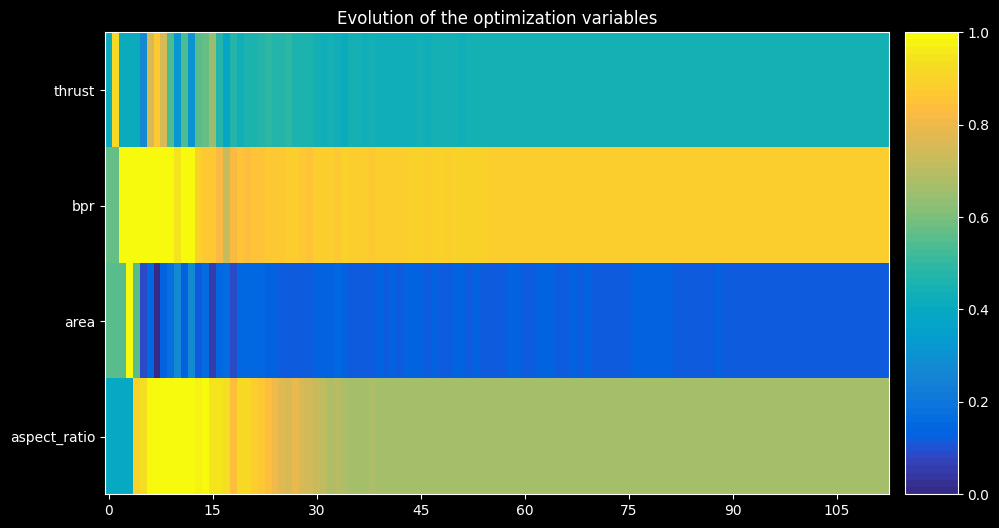

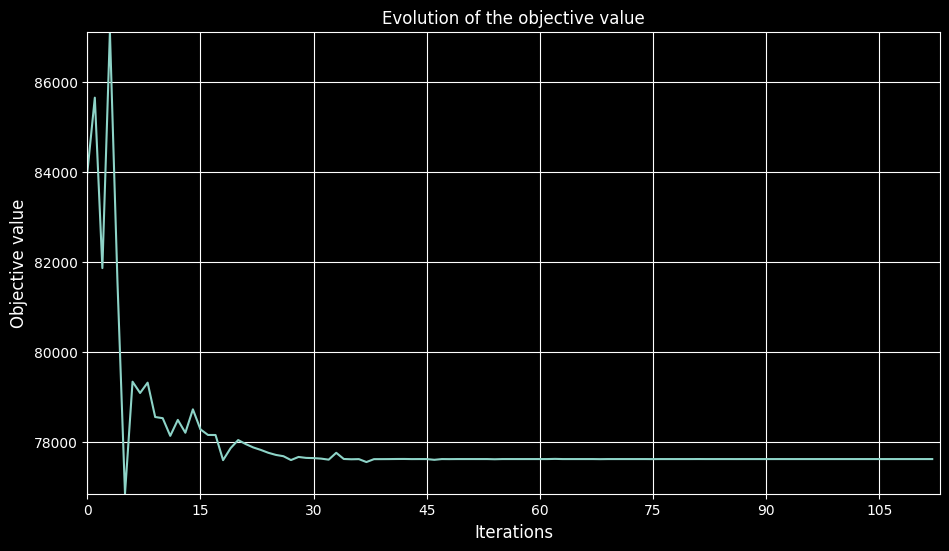

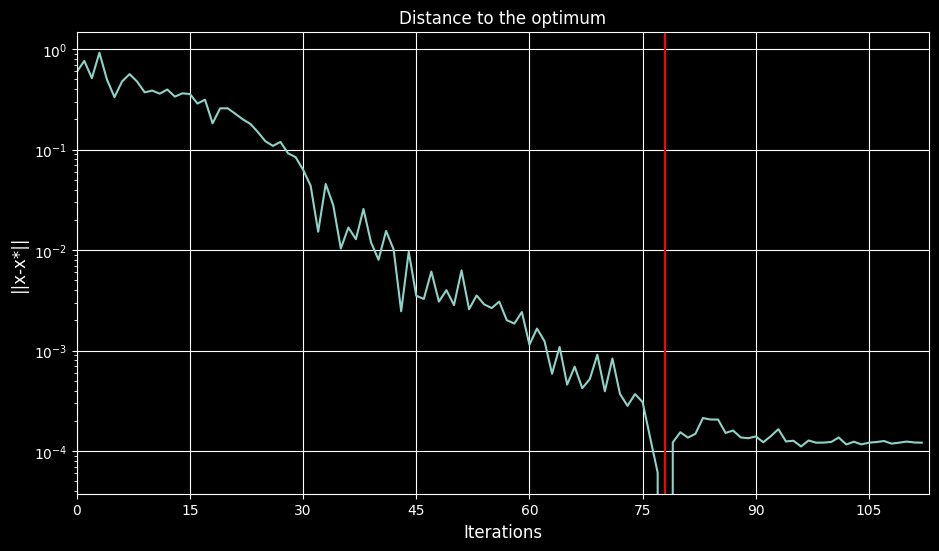

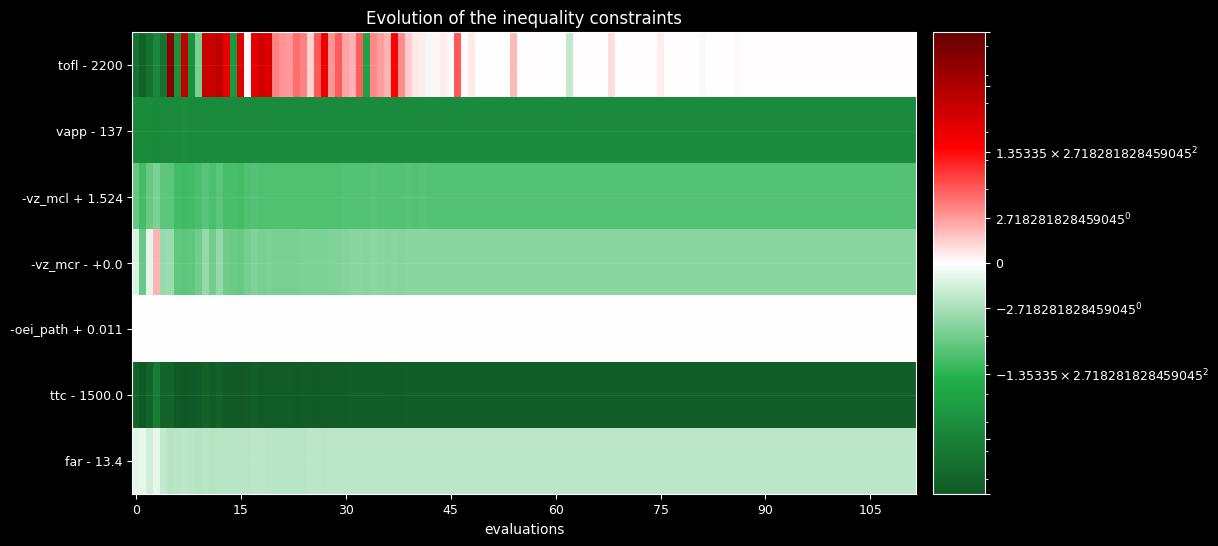

In [21]:
import matplotlib.pyplot as plt
scenario.post_process("OptHistoryView", save=False, show=False)
plt.show()

## II. Sub-Problem 2

## III. Sub-Problem 3